<a href="https://colab.research.google.com/github/vorst4/TUE_5LSM0_g6/blob/master/TUE_5LSM0_g6_dennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ------------------------------ Import modules ------------------------------ #

import os
import sys
import json
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from glob import glob
from datetime import datetime
from PIL import Image
from google.colab import drive

try:
  import rdp
except:
  !pip install rdp
  import rdp

# --------------------------------- Constants -------------------------------- #

N_classes = 9

N_train = 22799
N_val = 2532
N_test = 8238


# ---------------------- Import modules from Git source ---------------------- #

# efficient net
try:
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
except:
  print('\nInstalling efficient-net...')
  !pip install -e git+https://github.com/lukemelas/EfficientNet-PyTorch#egg=EfficientNet
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
  print('Done')

# # shap
# try:
#   import shap
# except:
#   print('\nInstalling shap...')
#   !pip install shap
#   import shap
#   print('Done')


# ----------------------------- Initialize Colab ----------------------------- #
#
# NOTE: all console commands (the ones that start with !) cannot be run from a 
# .py script. Usually this is possible using the command 'os.system('...')'.
# However, in Colab, it is for some reason not possible to obtain the console
# output of the command that is run. This makes it impossible to notify the user
# if an error occurs. All the commands therefore need to be run in the main
# .ipynb script (which is this script).
#


# check if GPU is enabled
if torch.cuda.is_available() == False:
  print('\nWARNING: GPU not enabled. Goto runtime -> change runtime type')


# mount Google Drive (if needed)
if not os.path.exists('drive'):
  print('\nMounting Google Drive...')
  drive.mount('/content/drive')
  print('Done')


# setup Git (if needed)
if not os.path.exists('TUE_5LSM0_g6'):
  print('\nSetting up git...')
  print('...Loading github.json from Google Drive')
  with open('/content/drive/My Drive/github.json', 'r') as json_file:
    gitconfig = json.load(json_file)
  print('...Cloning git repo')
  url = 'https://'+gitconfig["username"]+':'+gitconfig["key"]+\
        '@github.com/vorst4/TUE_5LSM0_g6.git'
  !git clone {url}
  print('...Setting username and email')
  !git -C TUE_5LSM0_g6 config user.name {gitconfig["username"]}
  !git -C TUE_5LSM0_g6 config user.email {gitconfig["email"]}
  print('Done')


# remove default sample_data folder (if needed)
if os.path.exists('sample_data'):
  print('\nRemoving sample_data...')
  os.system('rm -r sample_data')
  print('Done')


# copy and unzip data from Google Drive (if needed)
if not os.path.exists('ISIC_2019_Test_Input'):
  print('\nGetting data...')
  print('...Copying data.zip from Google Drive to workfolder')
  !cp 'drive/My Drive/5LSM0-final-assignment/data.zip' .
  print('...Unpacking data.zip')
  !unzip -q data.zip
  print('...Removing data.zip')
  !rm data.zip
  print('Done\n')


# ----------------------------- Import Functions ----------------------------- #
#
# NOTE: The modules need to be forcibly reloaded because Colab does not do this
# by default, even if the module has changed.
#

# append git dir to systems paths
sys.path.append('TUE_5LSM0_g6')

# dataloaders
import dataloaders
importlib.reload(dataloaders)
dataloaders = dataloaders.dataloaders

# train & accuracy
import train
importlib.reload(train)
accuracy = train.accuracy
train = train.train

# resnet18
import resnet18
importlib.reload(resnet18)
resnet18 = resnet18.resnet18

# backup
import backup
importlib.reload(backup)
backup = backup.backup

# restore
import restore
importlib.reload(restore)
restore = restore.restore

# isic_challenge_scoring (module, that does not change)
import isic_challenge_scoring
from isic_challenge_scoring.classification import ClassificationScore


# --------------------------------- Settings --------------------------------- #

# settings object
S = type('settings', (), {})()

# use gpu/cpu
if torch.cuda.is_available():
  S.device = torch.device('cuda')
else:
  S.device = torch.device('cpu')

# image size (squared)
S.modelname = 'efficientnet-b0'
S.img_size = EfficientNet.get_image_size(S.modelname)

# set variable type
S.dtype = torch.float32

# when to print
S.print_every = 100

# number of epochs to run
S.epochs = 50

# batch size, increase this until the RAM is full
S.batch_size = 32

# percentage of original train set that is to be used for validation
S.val_ratio = 10

# restore last backup of model?
S.load_backup = False

# Create backup each epoch?
S.backup_each_epoch = False

# Create backup if training is finished?
S.backup_on_finish = False

# model parameters
model_params = {
  'batch_norm_momentum': 0.99,
  'batch_norm_epsilon': 1e-3,
  'dropout_rate': 0.1,
  'drop_connect_rate': 0.2,
  'num_classes': N_classes }

# learning rate (with decay)
learning_rate = 1e-3
decayRate = 0.85


# ----------------------------------- Main ----------------------------------- #

# create data loader objects
dl_train, dl_val, dl_test = dataloaders(batch_size=S.batch_size,
                                        img_size = S.img_size)

# create model
model = EfficientNet.from_name(S.modelname, model_params)

# link data loaders to model
model.dl_train = dl_train
model.dl_val = dl_val
model.dl_test = dl_test

# load backup (if required)
if S.load_backup:
  model = restore(model, S.modelname)

# define optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
lr_exp = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# train
# train(model, optimizer, dl_train, dl_val, lr_exp, S)

# create csv file of test data
# make_cvs(model)


# ----------------------------------- End ------------------------------------ #


In [3]:
# ------------------------- GIT Pull, Commit & Push -------------------------- #

def git():

  if not input('\nPull? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 pull

  commit_msg = '\''+input('\nEnter commit message: ')+'\''

  if not input('\nCommit? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 add .
  !git -C /content/TUE_5LSM0_g6 commit -m {commit_msg}

  if not input('\nPush? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 push

git()

# ----------------------------------- End ------------------------------------ #



Pull? (y)y
Already up to date.

Enter commit message: finised function normalize_data

Commit? (y)y
[master a560904] finised function normalize_data
 2 files changed, 64 insertions(+), 106 deletions(-)
 rewrite normalize_data.py (68%)

Push? (y)y
Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1004 bytes | 1004.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/vorst4/TUE_5LSM0_g6.git
   abd02ba..a560904  master -> master


In [2]:

import pickle

bool_load_prev = False
filepath = 'drive/My Drive/5LSM0-final-assignment/validation-scores.pkl'

#
#   Evaluate model on test set
#

if not bool_load_prev:

  # release all variables stored on gpu
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

  # load model and move it to gpu if possible
  print('\nRestore latest model from drive')
  model = restore(model, S.modelname)
  model = model.to(device=S.device)

  # pre allocate variables
  y_true = torch.empty((N_val), device=torch.device('cpu'))
  scores = torch.empty((N_val, N_classes), device=torch.device('cpu'))
  x = torch.empty((S.batch_size, 3, S.img_size, S.img_size), device=S.device)

  # get batch_size samples
  print('\nEvaluate model on validation set')
  for t, (x, y) in enumerate(dl_val):
    print(x.is_cuda)
    x = x.to(device=S.device, dtype=S.dtype)
    tmp2 = (model(x)).to(device=torch.device('cpu'))
    try:
      y_true = torch.cat((y_true, y ) )
      scores = torch.cat((scores, tmp2 ) )
      break
    except:
      y_true = y
      scores = tmp2
      break
  print('done')


  print(y_true.shape)
  print(scores.shape)

  # save results
  print('\nStore scores to drive')
  with open(filepath, 'wb') as f:
      pickle.dump([y_true, scores], f)

else:
  with open(filepath, 'rb') as f:
    y_true, scores = pickle.load(f)


print('\n---------')


Restore latest model from drive

Restored model


Evaluate model on validation set
False
done
torch.Size([32])
torch.Size([32, 9])

Store scores to drive

---------


/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [21]:

import sklearn
import pandas as pd
import isic_challenge_scoring
importlib.reload(isic_challenge_scoring)


bool_use_weights = False

N_samples = y_true.shape[0]

# determine score probabilities
# tmp1 = np.exp(scores.detach())
# tmp2 = (tmp1.sum(1)).view(tmp1.shape[0], 1)
# p_scores = tmp1/tmp2
# p_scores = scores.detach()

tmp = scores.detach()
a = 
b = 0.5
p_scores = 1/((1 + e^(-(a*(tmp - b)))))

# make sure that every label occurs at least once in y_true. This is done by 
# setting sample <i> to class <i> (basically the first 9 samples to each class)
for i in range(N_classes):
  # set y_true
  y_true[i] = i
  # also change p_scores such that the data isn't crap
  tmp, idx = p_scores[i, :].max(0)
  p_scores[i, idx] = p_scores[i, i]
  p_scores[i, i] = tmp

# change y_true such that it has 9 columns, each with probability 0, 1
y_true2 = np.zeros((N_samples, N_classes))
for i in range(N_classes):
  y_true2[y_true==i, i] = 1
  

### weight ###
# determine number of images per label
N_imgs = np.zeros(N_classes)
for i in range(N_classes):
  N_imgs[i] = (y_true == i).sum()

# determine weight per label, depending on the (inverse) amount of images
w_lbl = 1/N_imgs
w_lbl = w_lbl / sum(w_lbl) # normalize it

# determine weight per image
if bool_use_weights:
  w = y_true2 * w_lbl
  w = w.sum(1) # only 1 non-zero element per row
else:
  w = np.ones(S.batch_size)


print('\n------------------------------------')
print('x.size = \t', list(x.size()) )
print('y_true = \t', list(y_true.shape))
print('y_true2 = \t', list(y_true2.shape))
print('scores = \t', list(scores.shape))
print('n_labels = \t', len(np.unique(y_true)))
print('labels = \t', np.unique(y_true))
print('p_scores = \t', list(p_scores.shape))
print('w = \t\t', list(w.shape))
print('------------------------------------\n')





------------------------------------
x.size = 	 [64, 3, 224, 224]
y_true = 	 [64]
y_true2 = 	 [64, 9]
scores = 	 [64, 9]
n_labels = 	 9
labels = 	 [0 1 2 3 4 5 6 7 8]
p_scores = 	 [64, 9]
w = 		 [64]
------------------------------------



In [4]:

score = sklearn.metrics.roc_auc_score(y_true2, p_scores)

print(score)


1.0


[0.         0.         0.         0.         0.         0.01666667
 0.03333333 0.05       0.06666667 0.08333333 0.1        0.11666667
 0.13333333 0.15       0.16666667 0.18333333 0.2        0.21666667
 0.23333333 0.25       0.26666667 0.28333333 0.3        0.31666667
 0.33333333 0.35       0.36666667 0.38333333 0.4        0.41666667
 0.43333333 0.45       0.46666667 0.48333333 0.5        0.51666667
 0.53333333 0.55       0.56666667 0.58333333 0.6        0.61666667
 0.63333333 0.65       0.66666667 0.68333333 0.7        0.71666667
 0.73333333 0.75       0.76666667 0.78333333 0.8        0.81666667
 0.83333333 0.85       0.86666667 0.88333333 0.9        0.91666667
 0.93333333 0.95       0.96666667 0.98333333 1.        ]
[0.   0.25 0.5  0.75 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   

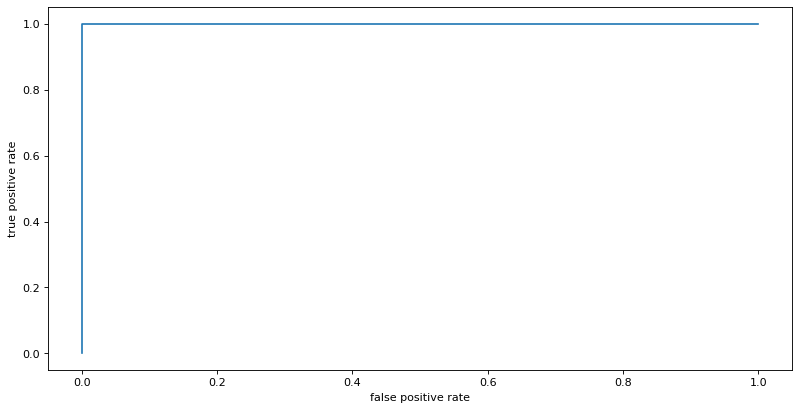

In [5]:

# roc_curve
fpr, tpr, thr = sklearn.metrics.roc_curve(y_true2[:, 0], 
                                          p_scores[:, 0], 
                                          sample_weight=w,
                                          drop_intermediate=False)

print(fpr)
print(tpr)
print(thr)


import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(fpr,tpr)
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()


In [6]:

# confusion matrix
categories = (0, 1, 2, 3, 4, 5, 6, 7, 8)
_, y_pred = p_scores.max(1)

confusion_matrix = sklearn.metrics.confusion_matrix( 
  y_true,
  y_pred,
  labels=categories,
  sample_weight=w/np.sum(w))

print(confusion_matrix)



[[0.0625   0.       0.       0.       0.       0.       0.       0.
  0.      ]
 [0.       0.09375  0.       0.       0.       0.       0.       0.
  0.      ]
 [0.       0.       0.109375 0.       0.       0.       0.       0.
  0.      ]
 [0.       0.       0.       0.015625 0.       0.       0.       0.
  0.      ]
 [0.       0.       0.       0.       0.171875 0.       0.       0.
  0.      ]
 [0.       0.       0.       0.       0.       0.46875  0.       0.
  0.      ]
 [0.       0.       0.       0.       0.       0.       0.03125  0.
  0.      ]
 [0.       0.       0.       0.       0.       0.       0.       0.015625
  0.      ]
 [0.       0.       0.       0.       0.       0.       0.       0.
  0.03125 ]]


In [22]:


yt = pd.DataFrame(y_true2.astype(np.float64))
p = pd.DataFrame((p_scores.numpy()).astype(np.float64))
weight = pd.DataFrame()
# tmp = w/sum(w).astype(np.float64)
weight.score_weight = pd.DataFrame((w/sum(w)).astype(np.float64))
weight.validation_weight = pd.DataFrame((w/sum(w)).astype(np.float64))
# weight.score_weight = None

ypl = p.idxmax(axis='columns')
ytl = yt.idxmax(axis='columns')
lbls = p.columns

# print(lbls)

# for att in dir(weight.score_weight):
#   if not att[0] == '_':
#     print(att)

print(dir(weight.score_weight.values.reshape(-1)))


confusion_matrix = sklearn.metrics.confusion_matrix( 
  ypl,
  ytl,
  labels=lbls,
  sample_weight=weight.score_weight.values.reshape(-1) )

print(confusion_matrix)





['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [24]:

performance = ClassificationScore(yt, p, weight)

print(performance.to_string())


Overall: 0    1.926872
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
dtype: float64
Validation: 0    1.926872
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
dtype: float64

Per-category metrics:
   accuracy  sensitivity  specificity      dice       ppv       npv       auc  auc_sens_80        ap
0  0.812500     1.000000     0.796610  0.454545  0.294118  1.000000  1.000000     1.000000  1.000000
1  0.812500     1.000000     0.785714  0.571429  0.400000  1.000000  0.975446     0.962054  0.914931
2  0.750000     1.000000     0.709091  0.529412  0.360000  1.000000  1.000000     1.000000  1.000000
3  0.968750     1.000000     0.967213  0.750000  0.600000  1.000000  0.994536     0.983607  0.916667
4  0.734375     1.000000     0.721311  0.260870  0.150000  1.000000  1.000000     1.000000  1.000000
5  0.875000     0.967742     0.787879  0.882353  0.810811  0.962963 